In [1]:
#导入相关数据库
from KRData.HKData import HKFuture
import talib as ta
import pandas as pd
import numpy as np
import configparser

In [2]:
#导入相关数据库
from KRData.HKData import HKFuture
import talib
import pandas as pd
import numpy as np

In [3]:
#引入画图函数
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [4]:
#连接数据库
cfParser = configparser.ConfigParser()
cfParser.read(r'config.ini')
hkfuture_config = cfParser['HKFuture']
hf = HKFuture(hkfuture_config.get('user'), hkfuture_config.get('password'))

In [7]:
#取数据，由20110101-20190401之间HSI的数据
trade_dates=hf.get_main_contract_trade_dates('HSI','20110101','20190401')

In [8]:
#策略逻辑
#构建开仓策略，后面用于循环
def strategy(df:pd.DataFrame):  #传入一个dataframe作为参数
    #设定每日交易时间
    _df = df.between_time('9:15', '16:30')
    #定义参数
    _high_value=0
    _low_value=600000
    _macd_golden_count=0
    _macd_dead_count=0
    _highest = []
    _lowest = []
    #假如该交易日没有交易数据，则输出空值。
    if len(_df) == 0:
        _open = []
        _close = []
        _highest=[]
        _lowest=[]
        _diff=0
        return  _open, _close,_highest,_lowest,_diff,_macd_golden_count,_macd_dead_count
    #当开盘价大于MA60的时候,取highest
    if _df.iloc[0]['gt_ma60']:
        #记录下来第一根K线作为开始的最高价，然后跟后面的数据来比较
        _highest=[_df.iloc[0]['datetime'],_df.iloc[0]['close']]
        #记录下来open/开仓信息，信息为交易时间，方向，开盘价格
        _open=[_df.iloc[0]['datetime'], '多', _df.iloc[0]['open']]
        #在这个交易日剩下的序列中构造一个循环判断平仓的信息
        for t, v in _df.iloc[1:].iterrows():
            #取区间内的最高值
            if v['close']>_high_value:
                _high_value = v['close']
                _highest=[v['datetime'],_high_value]
            #在开多仓的情况下，如果K线下穿ma60，则记录平仓信息_close
            if not v['gt_ma60']:
                #记录平仓信息，其中包括在循环中第一个出现小于ma60的时间点，交易方向，开仓价格
                _close=[v['datetime'], '空', v['open']]
                break
        #假如当日行情中没有成交，则在收盘的时候平仓
        else:
            _close=[_df.iloc[-1]['datetime'], '空', _df.iloc[-1]['open']]
       
        #MACD计数
        #由入场到最高点之间的时间区域
        _during_trading = _df[_open[0]: _highest[0]]['macd_type']
        #计算出现了多少次金叉
        _macd_golden_count = len(_during_trading[_during_trading == 2])
        #计算出翔了多少次死叉
        _macd_dead_count = len(_during_trading[_during_trading == 1])
        #最高值与收盘价差值
        _diff=_highest[1]-_df.at[_close[0], 'close']
    
    #开盘价小于ma60的情况，取lowest
    else:
        #记录下来第一根K线作为开始的最低价，然后跟后面的数据来比较
        _lowest=[_df.iloc[0]['datetime'],_df.iloc[0]['close']]
        #记录下来open/开仓信息，信息为交易时间，方向，开盘价格
        _open=[_df.iloc[0]['datetime'], '空', _df.iloc[0]['open']]
        #在这个交易日剩下的序列中构造一个循环来判断平仓信息
        for t, v in _df.iloc[1:].iterrows():
            #取区间内的最低值
            if v['close']<_low_value:
                _low_value = v['close']
                _lowest=[v['datetime'],_low_value]
            #在开空仓的情况下，如果K线上穿ma60，则记录平仓信息_close
            if v['gt_ma60']:
                #记录平仓信息，其中包括在循环中第一个出现大于ma60的时间点，交易方向，开仓价格
                _close=[v['datetime'], '多', v['open']]
                break
        #假如在当日行情中没有成交的话，则在收盘的时候平仓
        else:
            _close=[_df.iloc[-1]['datetime'], '多', _df.iloc[-1]['open']]
        
        #MACD计算
        _during_trading = _df[_open[0]: _lowest[0]]['macd_type']
        _macd_golden_count = len(_during_trading[_during_trading == 2])
        _macd_dead_count = len(_during_trading[_during_trading == 1])
        #计算出场点和最低点的差值
        _diff=_df.at[_close[0], 'close'] - _lowest[1]
 
    #返回_open和_close值，_highest值,_lowest值
    return   _open, _close,_highest,_lowest,_diff,_macd_golden_count,_macd_dead_count

In [9]:
#通用函数计算
#创建一个列表来装计算出来的结果
ret_list=[]
#设置一个循环来遍历每个合约的代码和对应的交易时间段
for code,tds in trade_dates.items():
    #输出结果
    print(f'code:{code}    {tds[0]}->{tds[-1]}')
    #取数据的函数
    data=hf.get_bars(code,fields=['datetime','open','high','low','close','trade_date'],start=tds[0],end=tds[-1])
    data_head: pd.DataFrame=hf.get_bars(code,fields=['datetime','open','high','low','close','trade_date'],end=data.iloc[0]['datetime'],bar_counts=60)[:-1]
    data = data_head.append(data)
    data['last_close'] = data['close'].shift(1)
    data['ma60']=talib.MA(data['close'],timeperiod=60)
    data['gt_ma60']=data['close']>data['ma60']
    #通过位元算来计算金叉死叉出现的次数
    data['macd'],data['diff'],data['dea']=ta.MACD(data.close.values,fastperiod=6,slowperiod=12,signalperiod=9)
    data['macd_gt0'] = (data['macd']>=0).astype(np.int8)
    data['macd_gt0_1'] = (data['macd_gt0'].shift(1).fillna(0)).astype(np.int8)
    data['macd_type'] = (data['macd_gt0_1'].values << 1) + data['macd_gt0'].values
    #按日期分组函数
    g=data.groupby('trade_date')
    #按日期来执行策略
    ret=g.apply(strategy)
    #将结果组合起来
    ret_list.append(ret)

code:HSI1101    2011-01-03 00:00:00->2011-01-28 00:00:00
code:HSI1102    2011-01-31 00:00:00->2011-02-25 00:00:00
code:HSI1103    2011-02-28 00:00:00->2011-03-30 00:00:00
code:HSI1104    2011-03-31 00:00:00->2011-04-28 00:00:00
code:HSI1105    2011-04-29 00:00:00->2011-05-30 00:00:00
code:HSI1106    2011-05-31 00:00:00->2011-06-29 00:00:00
code:HSI1107    2011-06-30 00:00:00->2011-07-28 00:00:00
code:HSI1108    2011-07-29 00:00:00->2011-08-30 00:00:00
code:HSI1109    2011-08-31 00:00:00->2011-09-30 00:00:00
code:HSI1110    2011-10-03 00:00:00->2011-10-28 00:00:00
code:HSI1111    2011-10-31 00:00:00->2011-11-29 00:00:00
code:HSI1112    2011-11-30 00:00:00->2011-12-29 00:00:00
code:HSI1201    2011-12-30 00:00:00->2012-01-30 00:00:00
code:HSI1202    2012-01-31 00:00:00->2012-02-28 00:00:00
code:HSI1203    2012-02-29 00:00:00->2012-03-29 00:00:00
code:HSI1204    2012-03-30 00:00:00->2012-04-27 00:00:00
code:HSI1205    2012-04-30 00:00:00->2012-05-30 00:00:00
code:HSI1206    2012-05-31 00:0

In [10]:
#计算pnl
def calc_pnl(s):
    _open=s[0]
    _close=s[1]
    if _open and _close:
        #开盘价的取值，如果开盘开多单的话，取-_open[2],如果开空单的话，取_open[2]
        _open_values=_open[2] if _open[1]=='空' else -_open[2]
        #平仓的时候取值，如果平仓时开的是多单则取-_close[2],如果开多单的话，取_close[2]
        _close_values=_close[2] if _close[1]=='空' else -_close[2]
        
        return _open_values + _close_values
    
    else:
        return np.nan    

In [11]:
#将结果整合在一起
total_results=pd.concat(ret_list)
total_results_df = pd.DataFrame({'_diff': total_results.str[4], 'golden': total_results.str[5], 'dead': total_results.str[6], 'pnl': total_results.apply(calc_pnl)})
total_results_df.head(10)

,_diff,golden,dead,pnl
trade_date,,,,
2011-01-03,213.0,0,0,13.0
2011-01-04,60.0,0,1,49.0
2011-01-05,62.0,1,0,-24.0
2011-01-06,70.0,0,0,-43.0
2011-01-07,0.0,0,0,0.0
2011-01-10,34.0,1,0,-51.0
2011-01-11,115.0,0,1,-13.0
2011-01-12,67.0,2,2,123.0
2011-01-13,76.0,1,1,-8.0


In [14]:
#基于金叉的出现次数进行统计

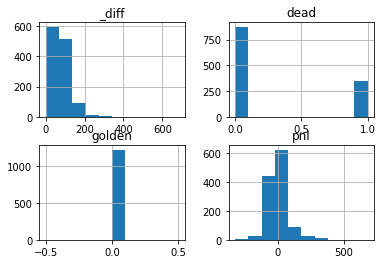

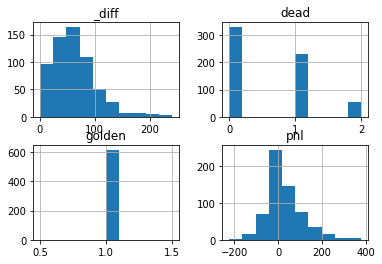

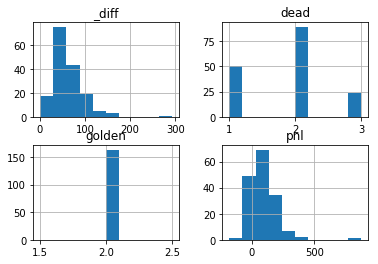

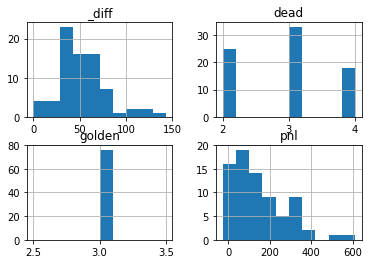

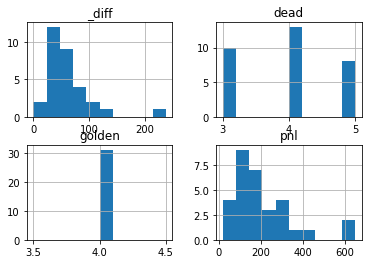

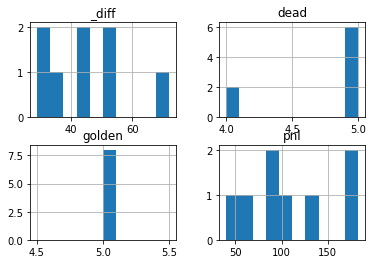

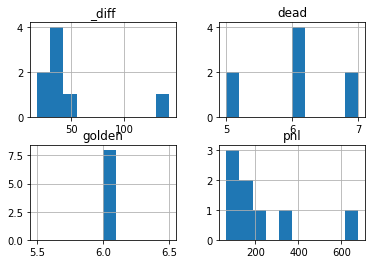

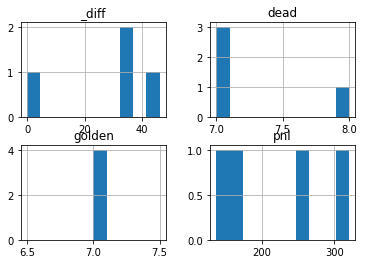

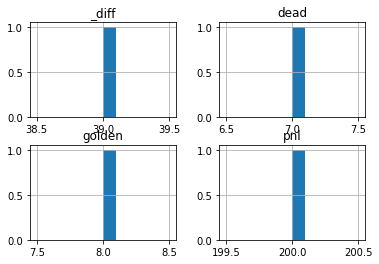

In [15]:
#统计在金叉出现不同次数下，其他参数的分布情况
for k, v in total_results_df.groupby('golden'):
    v.hist()

In [16]:
groupbyG=total_results_df.groupby('golden')

In [17]:
groupbyG['pnl'].count()

golden
0    1221
1     615
2     163
3      76
4      31
5       8
6       8
7       4
8       1
Name: pnl, dtype: int64

In [18]:
groupbyG['pnl'].sum()

golden
0    -1929.0
1    17661.0
2    15013.0
3    10924.0
4     6590.0
5      850.0
6     1779.0
7      882.0
8      200.0
Name: pnl, dtype: float64

In [19]:
groupbyG['pnl'].mean()

golden
0     -1.579853
1     28.717073
2     92.104294
3    143.736842
4    212.580645
5    106.250000
6    222.375000
7    220.500000
8    200.000000
Name: pnl, dtype: float64

In [20]:
groupbyG['pnl'].max()

golden
0    678.0
1    381.0
2    875.0
3    611.0
4    650.0
5    183.0
6    679.0
7    320.0
8    200.0
Name: pnl, dtype: float64

In [21]:
groupbyG['pnl'].min()

golden
0   -324.0
1   -224.0
2   -179.0
3    -28.0
4     19.0
5     40.0
6     63.0
7    137.0
8    200.0
Name: pnl, dtype: float64

In [22]:
ret1 = pd.DataFrame({'count':groupbyG['pnl'].count(),'max':groupbyG['pnl'].max(), 'min':groupbyG['pnl'].min(),  'mean':groupbyG['pnl'].mean(), 'sum':groupbyG['pnl'].sum()})

In [23]:
ret1

,count,max,min,mean,sum
golden,,,,,
0,1221,678.0,-324.0,-1.579853,-1929.0
1,615,381.0,-224.0,28.717073,17661.0
2,163,875.0,-179.0,92.104294,15013.0
3,76,611.0,-28.0,143.736842,10924.0
4,31,650.0,19.0,212.580645,6590.0
5,8,183.0,40.0,106.250000,850.0
6,8,679.0,63.0,222.375000,1779.0
7,4,320.0,137.0,220.500000,882.0
8,1,200.0,200.0,200.000000,200.0


In [24]:
ret1.to_excel('基于金叉统计结果.xlsx')

In [25]:
#基于死叉出现的情况进行统计

In [26]:
groupbyD=total_results_df.groupby('dead')

In [27]:
groupbyD['pnl'].count()

dead
0    1200
1     633
2     167
3      67
4      33
5      16
6       4
7       6
8       1
Name: pnl, dtype: int64

In [30]:
groupbyD['pnl'].sum()

dead
0    -2861.0
1    17702.0
2    18187.0
3     8478.0
4     5423.0
5     2406.0
6     1128.0
7     1246.0
8      261.0
Name: pnl, dtype: float64

In [31]:
groupbyD['pnl'].mean()

dead
0     -2.384167
1     27.965245
2    108.904192
3    126.537313
4    164.333333
5    150.375000
6    282.000000
7    207.666667
8    261.000000
Name: pnl, dtype: float64

In [32]:
groupbyD['pnl'].max()

dead
0    678.0
1    545.0
2    875.0
3    639.0
4    650.0
5    310.0
6    679.0
7    330.0
8    261.0
Name: pnl, dtype: float64

In [33]:
groupbyD['pnl'].min()

dead
0   -324.0
1   -179.0
2    -81.0
3    -21.0
4    -28.0
5     40.0
6     63.0
7     95.0
8    261.0
Name: pnl, dtype: float64

In [34]:
ret2 = pd.DataFrame({'count':groupbyD['pnl'].count(),'max':groupbyD['pnl'].max(), 'min':groupbyD['pnl'].min(),  'mean':groupbyD['pnl'].mean(), 'sum':groupbyD['pnl'].sum()})

In [35]:
ret2

,count,max,min,mean,sum
dead,,,,,
0,1200,678.0,-324.0,-2.384167,-2861.0
1,633,545.0,-179.0,27.965245,17702.0
2,167,875.0,-81.0,108.904192,18187.0
3,67,639.0,-21.0,126.537313,8478.0
4,33,650.0,-28.0,164.333333,5423.0
5,16,310.0,40.0,150.375000,2406.0
6,4,679.0,63.0,282.000000,1128.0
7,6,330.0,95.0,207.666667,1246.0
8,1,261.0,261.0,261.000000,261.0


In [36]:
ret2.to_excel('基于绿柱统计结果.xlsx')

_diff
(-0.683, 13.66]       5.624277
(13.66, 27.32]       20.448819
(27.32, 40.98]       59.725100
(40.98, 54.64]       40.981424
(54.64, 68.3]        41.220065
(68.3, 81.96]        15.813187
(81.96, 95.62]       19.270531
(95.62, 109.28]      -1.686667
(109.28, 122.94]     18.843373
(122.94, 136.6]     -13.653333
(136.6, 150.26]       7.058824
(150.26, 163.92]     16.080000
(163.92, 177.58]      6.095238
(177.58, 191.24]    -29.611111
(191.24, 204.9]     -44.857143
(204.9, 218.56]      44.777778
(218.56, 232.22]    -66.000000
(232.22, 245.88]    126.000000
(245.88, 259.54]    -69.000000
(259.54, 273.2]    -106.000000
(273.2, 286.86]     -58.000000
(286.86, 300.52]   -156.000000
(300.52, 314.18]           NaN
(314.18, 327.84]           NaN
(327.84, 341.5]     278.000000
(341.5, 355.16]     -32.000000
(355.16, 368.82]           NaN
(368.82, 382.48]           NaN
(382.48, 396.14]           NaN
(396.14, 409.8]            NaN
(409.8, 423.46]            NaN
(423.46, 437.12]           NaN
(4

<BarContainer object of 50 artists>

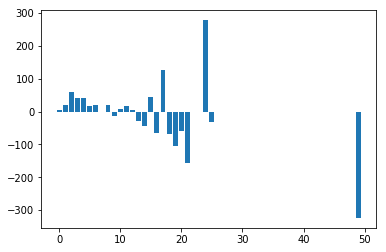

In [37]:
#最值和收盘价的偏离情况
grouped_by_diff=total_results_df.groupby(pd.cut(total_results_df['_diff'],bins=50))
print(grouped_by_diff.pnl.mean())
plt.bar(range(len(grouped_by_diff.pnl.mean())),grouped_by_diff.pnl.mean())